# Image segmentation using (Nested) U-Net

In [1]:
import os
import torch
import torchvision
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
from unet import UNet, NestedUNet
from utils import (
    load_checkpoint,
    get_dataloaders,
    check_accuracy
)

In [2]:
# configuration
SEED = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 3
NUM_WORKERS = 1
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
PIN_MEMORY = True
TEST_IMAGES_DIR = "./dataset/test/images"       # directory for test images
TEST_MASKS_DIR = "./dataset/test/masks"         # direcotry for test masks

torch.manual_seed(SEED)

### Dataset

Satellite water bodies images. Each image comes with a binary mask where white represents water and black represents anything else but water.

Dataset source: https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies

In [3]:
# define data augmentations for test sets
test_transform = A.Compose([
    A.Resize(IMAGE_WIDTH, IMAGE_HEIGHT),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# get test dataloader
train_dataloader, test_dataloader = get_dataloaders(
    train_img_dir=TEST_IMAGES_DIR,  # dummy, train dataloader is ignored
    train_mask_dir=TEST_MASKS_DIR,
    test_img_dir=TEST_IMAGES_DIR,
    test_mask_dir=TEST_MASKS_DIR,
    batch_size=BATCH_SIZE,
    train_transform=test_transform,  # dummy, train dataloader is ignored
    test_transform=test_transform,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

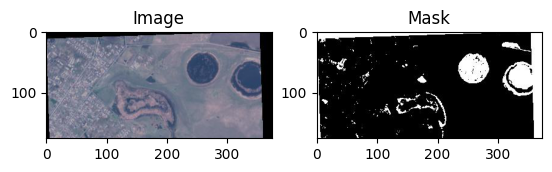

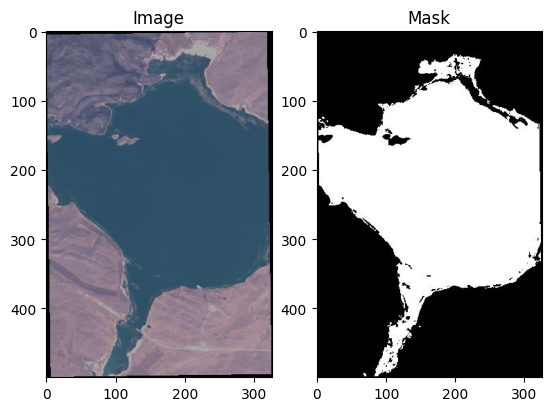

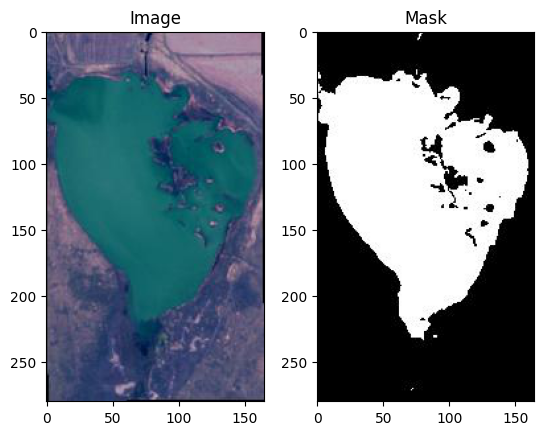

In [4]:
# sample a few images and masks
x, y, attributes = next(iter(test_dataloader))

# plot sampled images and masks
for f in attributes['filename']:
    _, axes_list = plt.subplots(1, 2)
    img = Image.open(os.path.join(TEST_IMAGES_DIR, f))
    mask = Image.open(os.path.join(TEST_MASKS_DIR, f))
    axes_list[0].imshow(img)
    axes_list[0].set_title("Image")
    axes_list[1].imshow(mask)
    axes_list[1].set_title("Mask")
    plt.show()


### Models

**U-Net**: A deep learning architecture for semantic segmentation tasks in computer vision. The U-Net architecture consists of two main parts: 

First, the contracting path is responsible for capturing features at different scales. It consists of multiple convolutional and max-pooling layers, which progressively reduce the spatial resolution while increasing the depth of feature maps.

Second, the expansive path is responsible for upsampling the feature maps to produce a segmentation map that has the same resolution as the input image. It consists of upsampling layers and skip connections that connect corresponding layers from the contracting and expansive paths.

![U-Net architecture diagram](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

**Nested U-Net (U-Net++)**: An extension of the U-Net architecture that adds multiple nested levels of skip connections and feature aggregation to improve segmentation performance.

Paper: [UNet++: A Nested U-Net Architecture for Medical Image Segmentation (Zhou et al., 2018)](https://arxiv.org/abs/1807.10165)

![Nested U-Net architecture diagram](https://production-media.paperswithcode.com/methods/unet_CKUFAmj.png)

In [5]:
# U-Net model
unet = UNet(num_classes=1, input_channels=3).to(DEVICE)
load_checkpoint(torch.load("./model/UNET_BCE_DICE_LOSS_checkpoint.pth"), unet)

# nested U-Net model
nested_unet = NestedUNet(num_classes=1, input_channels=3).to(DEVICE)
load_checkpoint(torch.load("./model/NESTED_UNET_BCE_DICE_LOSS_checkpoint.pth"), nested_unet)

### Loss

A combination of BCE Loss and Dice Loss was used for training.

$$Loss = 0.5 * BCELoss + DiceLoss$$

### Results

#### U-Net

In [6]:
scores = check_accuracy(test_dataloader, unet, device=DEVICE)

Accuracy   0.90129
F1         0.80189
Jaccard    0.70638
Dice       0.80189
Recall     0.79777
Precision  0.85113


In [8]:
unet.eval()

# make batch predictions
x = x.to(device=DEVICE)
with torch.no_grad():
    preds = torch.sigmoid(unet(x))

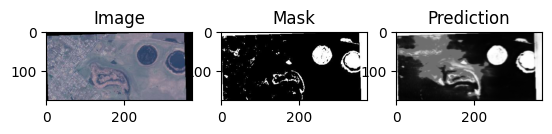

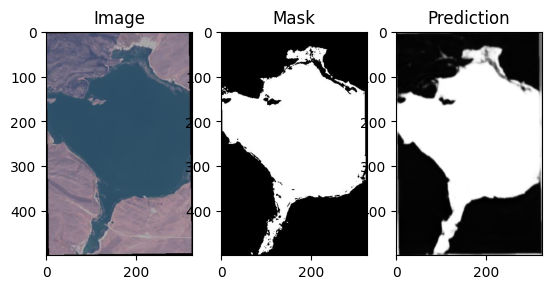

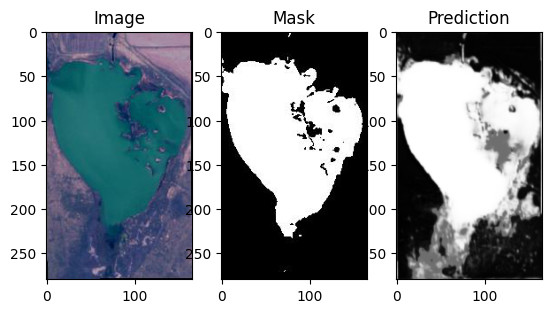

In [11]:
# display each predicted label along with the original image and mask
filenames = attributes['filename']
heights, widths = attributes['size']
heights, widths = heights.tolist(), widths.tolist()
for pred, width, height, f in zip(preds, widths, heights, filenames):
    # convert back to original image size
    size = (width, height)
    resize = torchvision.transforms.Resize(size, antialias=True)
    pred = resize(pred)
    pred = torch.einsum('cwh->whc', pred).cpu().numpy()
    # display
    _, axes_list = plt.subplots(1, 3)
    img = Image.open(os.path.join(TEST_IMAGES_DIR, f))
    mask = Image.open(os.path.join(TEST_MASKS_DIR, f))
    axes_list[0].imshow(img)
    axes_list[0].set_title("Image")
    axes_list[1].imshow(mask)
    axes_list[1].set_title("Mask")
    axes_list[2].imshow(pred, cmap="gray")
    axes_list[2].set_title("Prediction")
    plt.show()

#### Nested U-Net

In [7]:
scores = check_accuracy(test_dataloader, nested_unet, device=DEVICE)

Accuracy   0.90845
F1         0.80408
Jaccard    0.71047
Dice       0.80408
Recall     0.84550
Precision  0.80466


In [98]:
nested_unet.eval()

# make batch predictions
x = x.to(device=DEVICE)
with torch.no_grad():
    preds = torch.sigmoid(nested_unet(x))

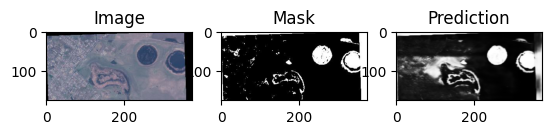

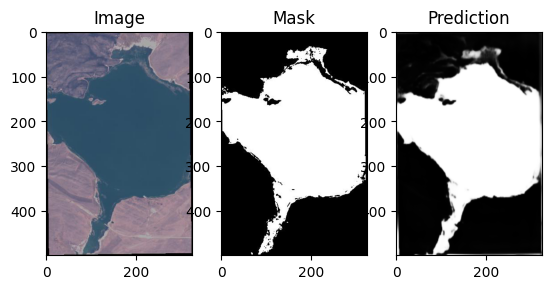

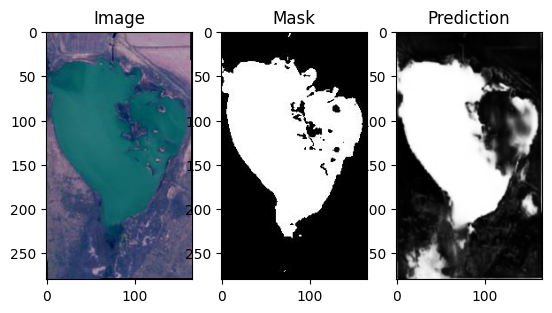

In [99]:
# display each predicted label along with the original image and mask
filenames = attributes['filename']
heights, widths = attributes['size']
heights, widths = heights.tolist(), widths.tolist()
for pred, width, height, f in zip(preds, widths, heights, filenames):
    # convert back to original image size
    size = (width, height)
    resize = torchvision.transforms.Resize(size, antialias=True)
    pred = resize(pred)
    pred = torch.einsum('cwh->whc', pred).cpu().numpy()
    # display
    _, axes_list = plt.subplots(1, 3)
    img = Image.open(os.path.join(TEST_IMAGES_DIR, f))
    mask = Image.open(os.path.join(TEST_MASKS_DIR, f))
    axes_list[0].imshow(img)
    axes_list[0].set_title("Image")
    axes_list[1].imshow(mask)
    axes_list[1].set_title("Mask")
    axes_list[2].imshow(pred, cmap="gray")
    axes_list[2].set_title("Prediction")
    plt.show()